# Causal programming demo

## Pull in our dependencies

In [1]:
(require '[acausal.core :refer [defmodel model->svg]])

## Define a model

$$w = f_w(\epsilon_w)$$
$$x = f_x(\epsilon_x)$$
$$y = f_y(z, \epsilon_y)$$
$$z = f_z(w, x, \epsilon_z)$$

$$\epsilon_w \not ⫫ \epsilon_z$$
$$\epsilon_x \not ⫫ \epsilon_y$$

In [2]:
(defmodel m
  "An example structural causal model"
  {:w []
   :x []
   :y [:z]
   :z [:w :x]}
    
  #{:w :z}
  #{:x :y})

#'user/m

In [3]:
(-> m :children :x)

#{:z}

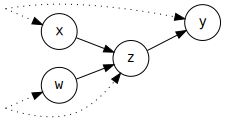

In [4]:
(model->svg m)